# Обработка данных об уязвимостях

In [1]:
import plotly.express as px
import polars as pl
from os import environ
from github import Github, Auth
from github.Repository import Repository
from ratelimiter import RateLimiter
from const import GITHUB_COMMIT_DATA_PATH, GITHUB_CVES_DATA_PATH, CVE_PROJECT_CVES_DATA_PATH, RESULTED_IMAGES
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
cve_data: pl.DataFrame = pl.concat([pl.read_csv(GITHUB_CVES_DATA_PATH), pl.read_csv(CVE_PROJECT_CVES_DATA_PATH).select(["cve_id", "reference", "cwe_id"])])
# Extact year from cve_id, so 2021-45835 is 2021
cve_data = cve_data.with_columns(pl.col("cve_id").str.split(by="-").list.get(0).str.to_integer().alias("year"))
cve_data.head()

cve_id,reference,cwe_id,year
str,str,str,i64
"""2021-45835""","""https://github…","""CWE-434""",2021
"""2021-45835""","""https://github…","""CWE-434""",2021
"""2021-45835""","""https://www.ex…","""CWE-434""",2021
"""2022-26521""","""https://github…","""CWE-434""",2022
"""2022-26521""","""http://packets…","""CWE-434""",2022


In [5]:
commit_refs = cve_data.filter(pl.col("reference").str.contains("commit")).drop_nulls()
counted_data = (
    cve_data.with_columns(pl.col("reference").str.contains("commit").alias("has_commit_link"))
    .group_by(by=["year", "cve_id"])
    .agg(pl.col("has_commit_link").max().alias("has_commit_link"))
    .group_by(by=["year"])
    .agg(pl.col("has_commit_link").sum().alias("with_commit_count"), pl.count().alias("total_count"))
    .filter((pl.col("year") >= 2015).and_(pl.col("year") <= 2023))
    .sort(by="year")
)
print(
    "Соотношение количества уязвимостей с открытым исходным кодом к общему количеству: "
    f'{counted_data.select(pl.col("year"), (pl.col("with_commit_count") / pl.col("total_count")).alias("ratio"))}'
)

Соотношение количества уязвимостей с открытым исходным кодом к общему количеству: shape: (9, 2)
┌──────┬──────────┐
│ year ┆ ratio    │
│ ---  ┆ ---      │
│ i64  ┆ f64      │
╞══════╪══════════╡
│ 2015 ┆ 0.103728 │
│ 2016 ┆ 0.116066 │
│ 2017 ┆ 0.088221 │
│ 2018 ┆ 0.087974 │
│ 2019 ┆ 0.089859 │
│ 2020 ┆ 0.093468 │
│ 2021 ┆ 0.106672 │
│ 2022 ┆ 0.123922 │
│ 2023 ┆ 0.107043 │
└──────┴──────────┘


## Исследование полученных данных

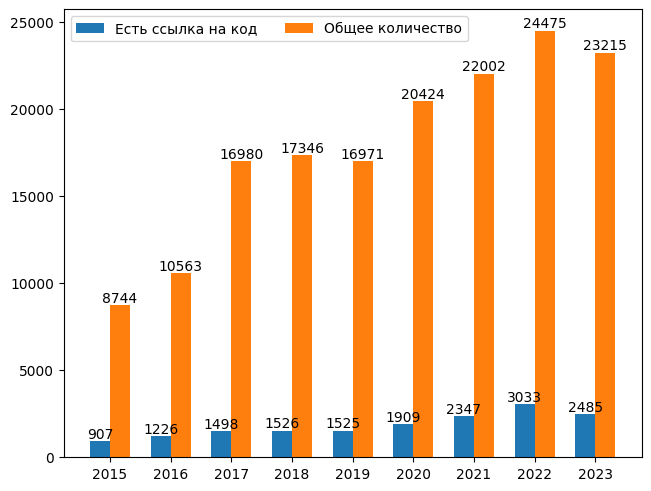

In [6]:
x = np.arange(len(counted_data.select("year")))  # the label locations
width = 0.33  # the width of the bars

fig, ax = plt.subplots(layout="constrained")

ax.bar_label(ax.bar(x, counted_data.select("with_commit_count").to_series(), width, label="Есть ссылка на код"))
ax.bar_label(ax.bar(x + width, counted_data.select("total_count").to_series(), width, label="Общее количество"))

ax.set_xticks(x + width / 2, counted_data.select("year").to_series())
ax.legend(loc="upper left", ncols=2)

plt.show()

## Получение информации о коммитах закрывающих уязвимость

In [7]:
github_refs = commit_refs.filter(
    pl.col("reference").str.contains(r"https:\/\/[w\.]*github\.com\/([\w\-_]+\/[\w\-_]+)\/commit.*")
).with_columns(
    pl.col("reference")
    .str.extract(r"https:\/\/[w\.]*github\.com\/([\w\-_]+\/[\w\-_]+)\/", group_index=1)
    .alias("repo"),
    pl.col("reference").str.extract(r".*\/commits*\/(\w+)", group_index=1).alias("commit"),
)

## Процесс сбора данных о коммитах

Будет работать долго, но если выполнение упадет, можно перезапустить и уже собранные данные не будет заново обновлять.

In [ ]:
auth = Auth.Token(environ["GITHUB_TOKEN"])
github_client = Github(auth=auth)
repos: dict[str, Repository] = {}

for repo_name in github_refs.select("repo").unique("repo").to_series():
    if repo_name in repos:
        continue
    repos[repo_name] = github_client.get_repo(repo_name, lazy=True)

commit_data: list[dict[str, str | int]] = []
# You can use this to resume the script if it crashes
checked_commits = {commit["commit"] for commit in commit_data}
rate_limiter = RateLimiter(max_calls=1, period=1)
for commit in github_refs.iter_rows(named=True):
    repo = repos[commit["repo"]]
    if commit["commit"] in checked_commits:
        continue
    with rate_limiter:
        try:
            commit_obj = repo.get_commit(commit["commit"])
            for commited_file in commit_obj.files:
                commit_data.append(
                    {
                        "repo": commit["repo"],
                        "commit": commit["commit"],
                        "file": commited_file.filename,
                        "status": commited_file.status,
                        "additions": commited_file.additions,
                        "deletions": commited_file.deletions,
                        "changes": commited_file.changes,
                        "patch": commited_file.patch,
                        "file_url": commited_file.raw_url,
                    }
                )
        except Exception as e:
            print("Error: ", e)

pl.DataFrame(commit_data).write_csv(GITHUB_COMMIT_DATA_PATH)

In [8]:
fix_commits = pl.read_csv(GITHUB_COMMIT_DATA_PATH)
fix_commits = fix_commits.with_columns(pl.col("cve_id").str.split(by="-").list.get(0).str.to_integer().alias("year"))
# extract file extension
fix_commits = fix_commits.with_columns(pl.col("file").str.extract(r".*\.(.*)", group_index=1).alias("file_extension"))
fix_commits = fix_commits.with_columns(
    pl.col("file_extension")
    .replace(
        {
            "c": "C",
            "h": "C",
            "cpp": "C++",
            "hpp": "C++",
            "cc": "C++",
            "hh": "C++",
            "java": "Java",
            "py": "Python",
            "js": "JavaScript",
            "ts": "TypeScript",
            "tsx": "TypeScript",
            "go": "Go",
            "rb": "Ruby",
            "php": "PHP",
            "phtml": "PHP",
            "cs": "C#",
            "swift": "Swift",
            "scala": "Scala",
            "rs": "Rust",
            "kt": "Kotlin",
            "clj": "Clojure",
            "cljc": "Clojure",
            "cljs": "Clojure",
            "groovy": "Groovy",
            "scala": "Scala",
            "dart": "Dart",
            "lua": "Lua",
            "r": "R",
            "sh": "Shell",
            "bash": "Shell",
            "zsh": "Shell",
            "ps1": "PowerShell",
            "psm1": "PowerShell",
            "bat": "Batchfile",
            "cmd": "Batchfile",
            "awk": "Awk",
            "yml": "YAML",
            "yaml": "YAML",
            "json": "JSON",
            "xml": "XML",
            "html": "HTML",
            "css": "CSS",
            "scss": "SCSS",
            "less": "Less",
            "styl": "Stylus",
            "sql": "SQL",
            "pl": "Perl",
            "jl": "Julia",
            "hcl": "HCL",
            "tf": "terraform",
        }
    )
    .alias("language")
).filter(pl.Expr.not_(pl.col("language").is_in(["txt", "md", "JSON", "YAML"])))
fix_commits.describe()

describe,repo,commit,file,status,additions,deletions,changes,patch,file_url,cve_id,year,file_extension,language
str,str,str,str,str,f64,f64,f64,str,str,str,f64,str,str
"""count""","""175824""","""175824""","""175824""","""175824""",175824.0,175824.0,175824.0,"""175824""","""175824""","""175824""",175824.0,"""175824""","""175824"""
"""null_count""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,"""9647""","""1""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,46.13621,19.087514,65.223724,null,null,null,2020.273569,null,null
"""std""",null,null,null,null,598.739615,399.218708,898.969716,null,null,null,2.605919,null,null
"""min""","""00xc/xml-rs""","""000030feb7a30f…",""".DS_Store""","""added""",0.0,0.0,0.0,"""@@ -0,0 +1 @@ …","""https://github…","""1999-0199""",1999.0,"""0/CREDITS""","""0/CREDITS"""
"""25%""",null,null,null,null,1.0,0.0,2.0,null,null,null,2019.0,null,null
"""50%""",null,null,null,null,5.0,1.0,9.0,null,null,null,2021.0,null,null
"""75%""",null,null,null,null,19.0,5.0,29.0,null,null,null,2022.0,null,null
"""max""","""zzxiang/extern…","""v4""","""zproject/urls.…","""renamed""",107422.0,101208.0,208630.0,"""@@ -999,7 +999…","""https://github…","""2023-7076""",2023.0,"""zsh-theme""","""zsh-theme"""


In [20]:
def get_languages_with_vulnerabilities_data(from_year: int, to_year: int) -> pl.DataFrame:
    fix_commits_filtered = fix_commits.filter((pl.col("year") >= from_year).and_(pl.col("year") <= to_year))
    top_languages = set(
        fix_commits_filtered.group_by(by="language")
        .count()
        .sort(by="count", descending=True)
        .limit(10)
        .select(pl.col("language"))
        .to_series()
    )
    return (
        fix_commits_filtered.unique(["cve_id", "language"])
        .join(cve_data.unique(["cve_id", "cwe_id"]), on="cve_id")
        .drop_nulls()
        .filter(pl.col("language").is_in(top_languages))
    )
    

def get_language_with_cwes_count_data(from_year: int, to_year: int) -> pl.DataFrame:
    language_with_vulnerabilities = get_languages_with_vulnerabilities_data(from_year, to_year)
    # count number of vulnerabilities per language and cwe_id, shows only top 10 cwe_id per language
    return (
        language_with_vulnerabilities.filter(pl.col("language").is_in(top_languages))
        .group_by(by=["language", "cwe_id"])
        .count()
        .sort(by=["language", "count"], descending=True)
        .with_columns(pl.col("language").cum_count().over("language").alias("language_count"))
        .with_columns(
            pl.when(pl.col("language_count") > 9).then(pl.lit("Другие CWEs")).otherwise(pl.col("cwe_id")).alias("cwe_id")
        )
    )


In [26]:
def draw_treemap_from_year(from_year: int, to_year: int, save_pic: bool = False):
    filtered_data = get_language_with_cwes_count_data(from_year, to_year)
    fig = px.treemap(
        filtered_data,
        path=["language", "cwe_id"],
        values="count",
        title=f"Количество уязвимостей по языкам программирования и CWE с {from_year} по {to_year} год",
        color="cwe_id",
        color_discrete_map={
            "(?)": "green",
            "Другие CWEs": "#cce7e8",
        },
    )
    fig.update_layout(font_family="Ubuntu", height=800, margin=dict(t=30, l=25, r=25, b=25))

    if save_pic:
        RESULTED_IMAGES.mkdir(parents=True, exist_ok=True)
        fig.write_image(RESULTED_IMAGES / "cwe_language_treemap.png")

    fig.show()
    
draw_treemap_from_year(2020, 2024, True)

In [52]:
draw_treemap_from_year(2015, 2020, False)

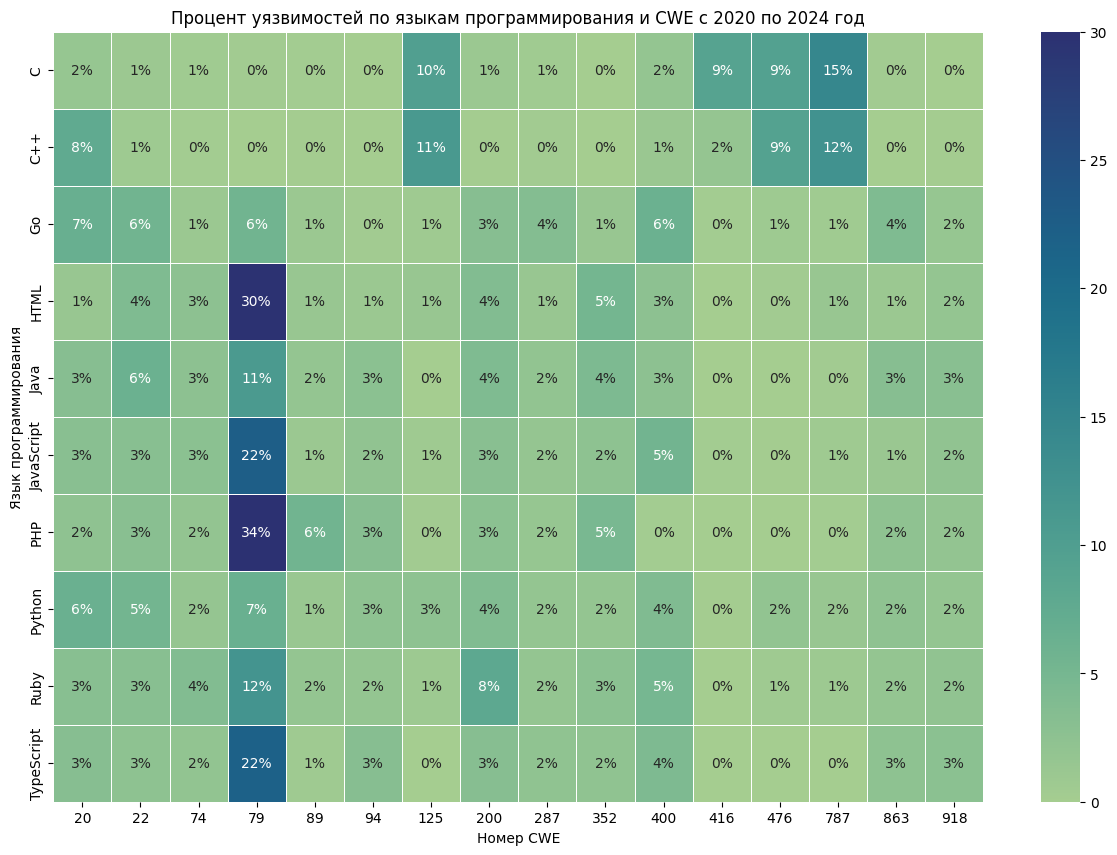

In [50]:
def draw_heatmap_from_year(from_year: int, to_year: int, save_pic: bool = False):
    filtered_data = get_languages_with_vulnerabilities_data(from_year, to_year)
    top_cwes = set(
        filtered_data.group_by(by="cwe_id")
        .count()
        .sort(by="count", descending=True)
        .limit(16)
        .select(pl.col("cwe_id"))
        .to_series()
    )
    top_cwes_commits = filtered_data.filter(pl.col("cwe_id").is_in(top_cwes))
    # Count amount of commits per language
    commits_count = filtered_data.select("language").group_by(by="language").agg(pl.count().alias("total_count"))
    top_cwes_commits = (
        top_cwes_commits.group_by(by=["language", "cwe_id"])
        .count()
        .join(commits_count, on="language")
        .with_columns(
            (pl.col("count") / pl.col("total_count") * pl.lit(100)).alias("percentage"),
            pl.col("cwe_id").str.replace("CWE-", "").str.to_integer(),
        )
        .to_pandas()
    )
    
    heatmap_data = top_cwes_commits.pivot(index="language", columns="cwe_id", values="percentage").fillna(0)

    fig, ax = plt.subplots(figsize=(15, 10))
    ax_heatmap = sns.heatmap(
        heatmap_data.sort_index(ascending = True, axis = 1),
        linewidths=0.5,
        cmap="crest",
        vmax=30,
        annot=True,
        ax=ax,
        fmt=".0f",
    )
    for t in ax_heatmap.texts:
        t.set_text(t.get_text() + "%")
    ax_heatmap.set(ylabel="Язык программирования", xlabel="Номер CWE")
    ax_heatmap.set_title(f"Процент уязвимостей по языкам программирования и CWE с {from_year} по {to_year} год")
    if save_pic:
        RESULTED_IMAGES.mkdir(parents=True, exist_ok=True)
        fig.savefig(RESULTED_IMAGES / "cwe_language_heatmap.png")


draw_heatmap_from_year(2020, 2024, True)

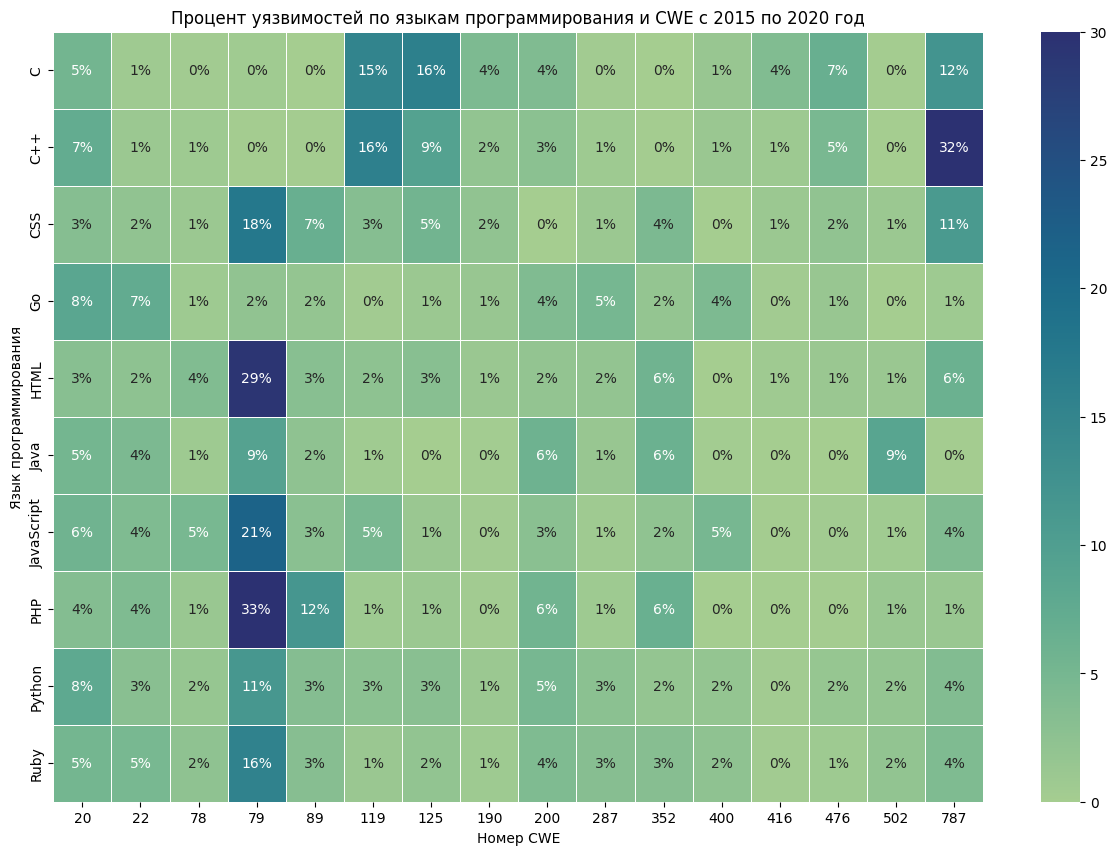

In [51]:
draw_heatmap_from_year(2015, 2020, False)